# Attunuation density study
This notebook carries out the preliminary study on attenuation densities in a region of interest (ROI). It compares a ROI in patient 000 and 002, that has GGO, with the same ROI in patient 018 without GGO.


In [ ]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Import function from other directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.join(parent_dir, "DataPreprocess"))
from main_preprocess import load_nifti_convert_to_numpy, convert_numpy_to_nifti_and_save

/Users/bruger/anaconda3/envs/bachelor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define base paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'
output_base_dir = "/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data/roi_ct_results"

In [4]:
data_paths = {
    "nifti": {
        "000": f"{data_path}/cropped_lungs_ct/lungCT_000_0000.nii.gz",
        "002": f"{data_path}/cropped_lungs_ct/lungCT_002_0000.nii.gz",
        "018": f"{data_path}/cropped_lungs_ct/lungCT_018_0000.nii.gz",
    },
    "roi_seg": {
        "000": f"{data_path}/roi_study_seg/roi_seg_000.nii.gz",
        "002": f"{data_path}/roi_study_seg/roi_seg_002.nii.gz",
        "018_0": f"{data_path}/roi_study_seg/roi_seg_018_0.nii.gz",
        "018_2": f"{data_path}/roi_study_seg/roi_seg_018_2.nii.gz"
    },
}

In [5]:
# Load data into a dictionary
loaded_data = {
    "ct": {
        key: load_nifti_convert_to_numpy(input_path=path)
        for key, path in data_paths["nifti"].items()
    },
    "roi_seg": {
        key: load_nifti_convert_to_numpy(input_path=path)
              for key, path in data_paths["roi_seg"].items()
    },
}

In [6]:
# Compute CT-ROI results and store in a dictionary
ct_roi_results = {
    "000": np.multiply(loaded_data["ct"]["000"], loaded_data["roi_seg"]["000"]),
    "002": np.multiply(loaded_data["ct"]["002"], loaded_data["roi_seg"]["002"]),
    "018_0": np.multiply(loaded_data["ct"]["018"], loaded_data["roi_seg"]["018_0"]),
    "018_2": np.multiply(loaded_data["ct"]["018"], loaded_data["roi_seg"]["018_2"])
}


In [7]:
# Define output paths with three-digit IDs
output_paths = {
    key: f"{output_base_dir}/roi_result_{key}.nii.gz"
    for key in ["000", "002", "018_0", "018_2"]
}

# Define a mapping of results to output paths
results_mapping = {
    "000": {"np_file": ct_roi_results["000"], "nifti_path": data_paths["nifti"]["000"]},
    "002": {"np_file": ct_roi_results["002"], "nifti_path": data_paths["nifti"]["002"]},
    "018_0": {"np_file": ct_roi_results["018_0"], "nifti_path": data_paths["nifti"]["018"]},
    "018_2": {"np_file": ct_roi_results["018_2"], "nifti_path": data_paths["nifti"]["018"]},
}

# Loop to save results
for key, paths in results_mapping.items():
    convert_numpy_to_nifti_and_save(
        np_file=paths["np_file"],
        output_path=output_paths[key],
        original_nifti_path=paths["nifti_path"],
    )


saving
saving
saving
saving


In [8]:
# Flatten CT-ROI results, filter out zeros, and store in a dictionary
seg_result_arrays = {
    key: (
        result.flatten()[(result.flatten() != 0) & (result.flatten() > -2000)] 
        if not isinstance(result, list) 
        else [
            r.flatten()[(r.flatten() != 0) & (r.flatten() > -2000)] 
            for r in result
        ]
    )
    for key, result in ct_roi_results.items()
}

In [9]:
# Define the function for calculating high-density percentage
def get_hpdr(arr, hpdr_low=-720, hpdr_high=-300):
    return sum((arr >= hpdr_low) & (arr <= hpdr_high)) / len(arr)

# Calculate high-density percentage for each result
high_density_percent = {
    key: get_hpdr(arr) for key, arr in seg_result_arrays.items()
}

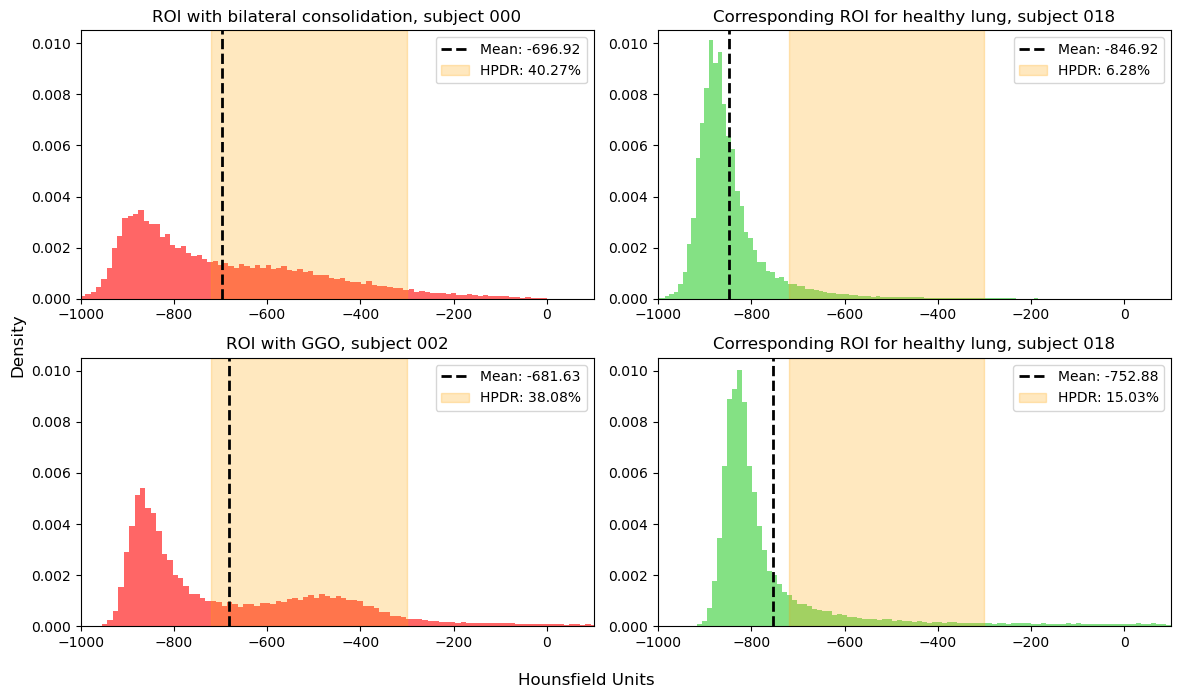

In [10]:
# Data and parameters to plot
seg_hpdr_results = [
    (seg_result_arrays["000"], 'ROI with bilateral consolidation, subject 000', high_density_percent["000"], 'red'),
    (seg_result_arrays["018_0"], 'Corresponding ROI for healthy lung, subject 018', high_density_percent["018_0"], 'limegreen'),
    (seg_result_arrays["002"], 'ROI with GGO, subject 002', high_density_percent["002"], 'red'),
    (seg_result_arrays["018_2"], 'Corresponding ROI for healthy lung, subject 018', high_density_percent["018_2"], 'limegreen'),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

for ax, (seg_result, title, hpdr_percent, color) in zip(axes.flatten(), seg_hpdr_results):
    mean_value = np.mean(seg_result)
    ax.hist(seg_result, bins=100, color=color, alpha=0.6, density=True)
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(title)
    ax.set_xlim(-1000, 100)
    ax.set_ylim(0, 0.0105)
    ax.axvspan(-720, -300, color='orange', alpha=0.25)
    ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")

fig.supxlabel('Hounsfield Units', fontsize=12)
fig.supylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()


# Statistical analysis

In [11]:
# Mann-Whitney U Test: test if distributions are the same (non-parametric for two groups)
_, pval_002_018_0 = stats.mannwhitneyu(seg_result_arrays["000"], seg_result_arrays["018_0"], alternative='two-sided')
_, pval_000_018_2 = stats.mannwhitneyu(seg_result_arrays["002"], seg_result_arrays["018_2"], alternative='two-sided')
_, pval_healthy = stats.mannwhitneyu(seg_result_arrays["018_0"], seg_result_arrays["018_2"], alternative='two-sided')

# Kolmogorov-Smirnov Test: test if two samples come from the same distribution
_, pval_002_018_0 = stats.ks_2samp(seg_result_arrays["000"], seg_result_arrays["018_0"])
_, pval_000_018_2 = stats.ks_2samp(seg_result_arrays["002"], seg_result_arrays["018_2"])
_, pval_healthy = stats.ks_2samp(seg_result_arrays["018_0"], seg_result_arrays["018_2"])

# Print results
pairs = [
    ("002 vs. 018_0", seg_result_arrays["000"], seg_result_arrays["018_0"]),
    ("000 vs. 018_2", seg_result_arrays["002"], seg_result_arrays["018_2"]),
    ("018_0 vs. 018_2", seg_result_arrays["018_0"], seg_result_arrays["018_2"]),
]

for label, arr1, arr2 in pairs:
    # Mann-Whitney U Test
    _, pval_mw = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')
    # Kolmogorov-Smirnov Test
    _, pval_ks = stats.ks_2samp(arr1, arr2)
    print(f"{label}: MW p-value = {pval_mw:.4f}, KS p-value = {pval_ks:.4f}")


002 vs. 018_0: MW p-value = 0.0000, KS p-value = 0.0000
000 vs. 018_2: MW p-value = 0.0000, KS p-value = 0.0000
018_0 vs. 018_2: MW p-value = 0.0000, KS p-value = 0.0000


In [12]:
# Sample
n_samples = 100000
sampled_data = {
    key: np.random.choice(arr, size=n_samples, replace=True)
    for key, arr in seg_result_arrays.items()
}


In [13]:
# Perform Kolmogorov-Smirnov tests on sampled data
pvals = {
    "000 vs. 018_0": stats.ks_2samp(sampled_data["000"], sampled_data["018_0"])[1],
    "002 vs. 018_2": stats.ks_2samp(sampled_data["002"], sampled_data["018_2"])[1],
    "018_0 vs. 018_2": stats.ks_2samp(sampled_data["018_0"], sampled_data["018_2"])[1],
}

# Print results with descriptive messages
for comparison, pval in pvals.items():
    print(f'{comparison} distributions are statistically significantly different with a p-value = {round(pval, 5)}')


000 vs. 018_0 distributions are statistically significantly different with a p-value = 0.0
002 vs. 018_2 distributions are statistically significantly different with a p-value = 0.0
018_0 vs. 018_2 distributions are statistically significantly different with a p-value = 0.0
